In [2]:
import pandas as pd
import re
import spacy
import numpy as np
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

from gensim.models import Word2Vec

from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
def clean_text(text, lower=True):
    prep_text = text.replace('\n', ' ')
    prep_text = prep_text.replace('\t', ' ')
    prep_text = re.sub(' +', ' ', prep_text)
    if lower:
        prep_text = prep_text.lower()
    prep_text = re.sub(r'\[.+?\]|\(.+?\)', '', prep_text)
    return prep_text


def clean_and_lemma_doc(text):
    doc = nlp(clean_text(text))
    lemma_doc = [token.lemma_ for token in doc if token.is_stop != True and token.is_punct != True and token.is_space != True and token.is_alpha]
    return lemma_doc

In [14]:
nlp = spacy.load('de')

In [15]:
df = pd.read_csv('./Data/aggregated_manifestos.csv').drop(columns=['Unnamed: 0'])

In [16]:
df.text = df.text.apply(clean_and_lemma_doc)

In [17]:
df.head()

,year,participation,party_name,result,text,type
0,1949,78.49,CDUCSU,31.01,"[düsseldorfer, leitsätze, juli, wirtschaftlich...",b
1,1949,78.49,FDP,11.92,"[bremer, plattform, beschlüsse, bundesparteita...",b
2,1949,78.49,Linke,NaN,"[einheit, frieden, wohlstand, wahlprogramm, kp...",b
3,1949,78.49,SPD,29.22,"[frei, deutschland, wählerinnen, wähler, augus...",b
4,1953,85.99,CDUCSU,45.17,"[hamburger, programm, april, deutsch, bundesta...",b


In [19]:
df.to_hdf('./cleaned_manifestos.h5', key='cleaned')

/Users/hao/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['party_name', 'text', 'type']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Create TF-IDF Matrix

In [20]:
docs = df.text

In [21]:
docs_dict = Dictionary(docs)
docs_dict.compactify()

In [22]:
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [23]:
tf_idf_df = pd.DataFrame(data=docs_vecs, columns=[val for val in docs_dict.values()])
tf_idf_df.head()

,abbau,abgabe,abgesunken,abhängig,abhängigkeit,ablehnen,abnehmen,abrechnen,absatz,absatzes,...,williger,wohlstandsmüll,wohnungsbeihilfe,wullenwever,zerren,zerrend,zeugend,zusatzgeräten,zwischenverbindungen,überhöhung
0,0.003508,0.007282,0.024198,0.007634,0.004213,0.020559,0.012497,0.026846,0.013266,0.020862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.011410,0.000000,0.000000,0.000000,0.038654,0.000000,0.000000,0.031178,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002087,0.000000,0.000000,0.000000,0.000000,0.007341,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.008228,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Traind Word Embeddings

In [24]:
docs_tokens = df.text

In [25]:
skipgram_model = Word2Vec(sentences=docs_tokens, size=100, window=5, min_count=1, workers=4, sg=1)
skipgram_model.save('./manifestos_skipgram.bin')

In [26]:
skipgram_model = Word2Vec.load('./manifestos_skipgram.bin')

In [27]:
skipgram_model.wv.word_vec('bezugscheinwirtschaft')

array([-1.15698995e-03,  1.21679217e-01,  2.44928822e-02,  5.97785413e-02,
        4.01937030e-02,  4.78249863e-02, -2.35397164e-02,  5.79504929e-02,
        3.20788920e-02, -1.00922715e-02,  4.93739247e-02, -4.25313525e-02,
        4.53923829e-02,  9.77517944e-03, -3.71850692e-02, -2.59076823e-02,
       -6.04864694e-02, -7.37708583e-02,  6.29639905e-03,  3.58028151e-02,
       -1.04943682e-02,  6.19309060e-02, -1.64802447e-02, -7.30538042e-04,
        4.01594676e-02, -3.29457596e-02,  5.01580499e-02,  2.21501011e-02,
        7.96977878e-02,  4.22059223e-02, -2.91662011e-02, -4.45791334e-02,
        1.16806161e-02,  6.07236549e-02, -2.88692731e-02,  1.65395793e-02,
       -1.55578824e-02, -4.17319089e-02,  3.09029804e-03, -7.08822682e-02,
        2.05745474e-02, -2.82006282e-02,  2.78713629e-02,  3.45528498e-02,
       -2.84268893e-02, -9.84738208e-03, -3.76115963e-02,  7.00825229e-02,
       -2.69233063e-02,  7.13571161e-02, -6.62105232e-02,  1.29402682e-01,
        6.35889247e-02,  

## Summarize Manifestos

In [28]:
summed_docs = []
for index, manifesto in df.iterrows():
    summed = np.zeros(100)
    for word in manifesto.text:
        word_vec = skipgram_model.wv.word_vec(word)
        summed += word_vec
    
    summed_docs.append(summed)

In [40]:
df['doc_sum'] = summed_docs

In [65]:
#df.to_hdf('./cleaned_manifestos_with_sums.h5', key='sums')
df = pd.read_hdf('./cleaned_manifestos_with_sums.h5')

In [70]:
def calc_cosine_df(df, party_a, party_b, typ='b'):
    filtered_df = df[df.type == typ]
    filtered_df = filtered_df[(filtered_df.party_name == party_a) | (filtered_df.party_name == party_b)]
    years = filtered_df.year.unique()
    
    years_list = []
    plot_distance = []
    party_names = []
    for year in years:
        filtered_year_df = filtered_df[filtered_df.year == year]
        if len(filtered_year_df) == 2:
            word_vec_a = filtered_year_df[filtered_year_df.party_name == party_a].doc_sum.values[0]
            word_vec_b = filtered_year_df[filtered_year_df.party_name == party_b].doc_sum.values[0]
            distance = cosine(word_vec_a, word_vec_b)

            distance_a = distance/2 * -1
            distance_b = distance/2
            chosen_parties = [party_a, party_b]

            for i, distance_x in enumerate([distance_a, distance_b]):
                years_list.append(year)
                plot_distance.append(distance_x)
                party_names.append(chosen_parties[i])
            
    return pd.DataFrame({'year': years_list, 'party_name': party_names, 'plt_distance': plot_distance})    

In [74]:
def plot_distance(df, party_a, party_b, typ='b'):
    distance_df = calc_cosine_df(df, party_a, party_b, typ)
    
    plt.figure(figsize=(10,8), dpi= 80)
    group_col = 'party_name'
    order_of_bars = distance_df.year.unique()

    colors = [plt.cm.Spectral(i/float(len(distance_df[group_col].unique())-1)) for i in range(len(distance_df[group_col].unique()))]

    for c, group in zip(colors, distance_df[group_col].unique()):
        sns.barplot(x='year', y='plt_distance', data=distance_df.loc[distance_df[group_col]==group, :], order=order_of_bars, color=c, label=group)

    plt.xlabel("Year")
    plt.ylabel("Distance")
    plt.yticks(fontsize=12)
    plt.title("Distance between Manifestos")
    plt.legend()
    plt.show()

In [75]:
distance_df = calc_cosine_df(df, 'CDUCSU', 'SPD')

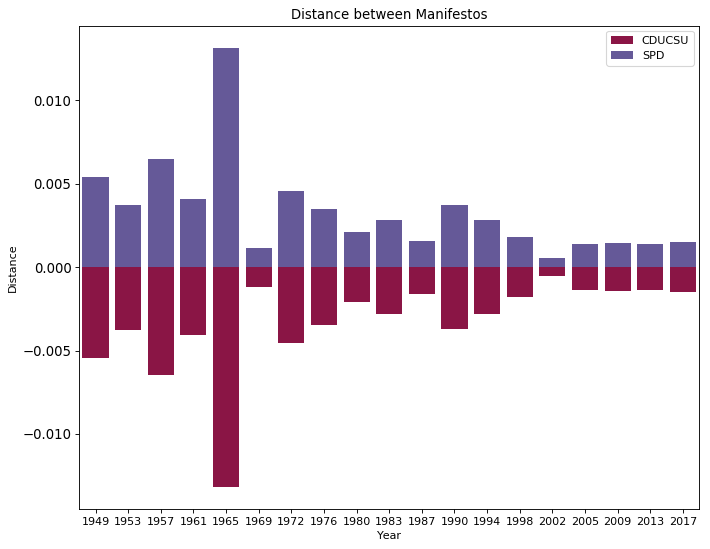

In [82]:
plot_distance(df, 'CDUCSU', 'SPD')

In [79]:
df.party_name.unique()

array(['CDUCSU', 'FDP', 'Linke', 'SPD', 'Gruene', 'AFD'], dtype=object)

In [ ]:
color_dic = {
    'CDUCSU': 'black'
}

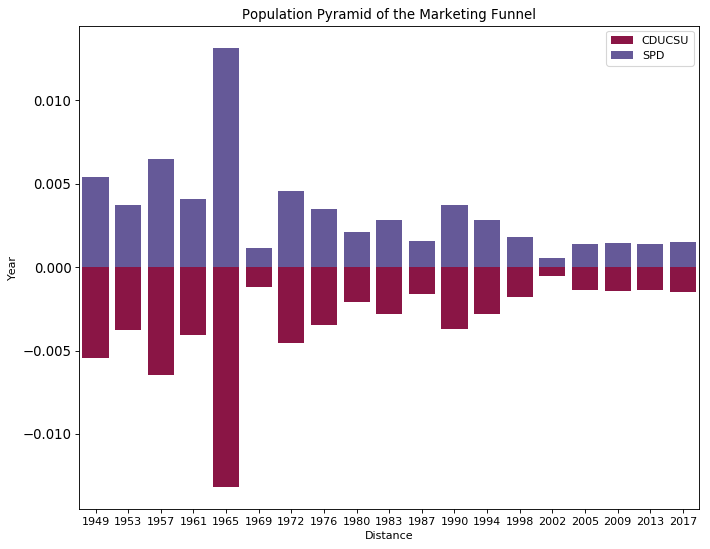

In [60]:
plt.figure(figsize=(10,8), dpi= 80)
group_col = 'party_name'
order_of_bars = distance_df.year.unique()

colors = [plt.cm.Spectral(i/float(len(distance_df[group_col].unique())-1)) for i in range(len(distance_df[group_col].unique()))]

for c, group in zip(colors, distance_df[group_col].unique()):
    sns.barplot(x='year', y='plt_distance', data=distance_df.loc[distance_df[group_col]==group, :], order=order_of_bars, color=c, label=group)

plt.xlabel("Distance")
plt.ylabel("Year")
plt.yticks(fontsize=12)
plt.title("Distance between Manifestos")
plt.legend()
plt.show()

In [61]:
colors = [plt.cm.Spectral(i/float(len(distance_df[group_col].unique())-1)) for i in range(len(distance_df[group_col].unique()))]


In [62]:
colors

[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0),
 (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)]

In [33]:
distance_df.loc[distance_df[group_col]==group, :]

,year,party_name,plt_distance
1,1949,SPD,0.005436
3,1953,SPD,0.003759
5,1957,SPD,0.006465
7,1961,SPD,0.004095
9,1965,SPD,0.013174
11,1969,SPD,0.001178
13,1972,SPD,0.004556
15,1976,SPD,0.003468
17,1980,SPD,0.002113
19,1983,SPD,0.002807


/Users/hao/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


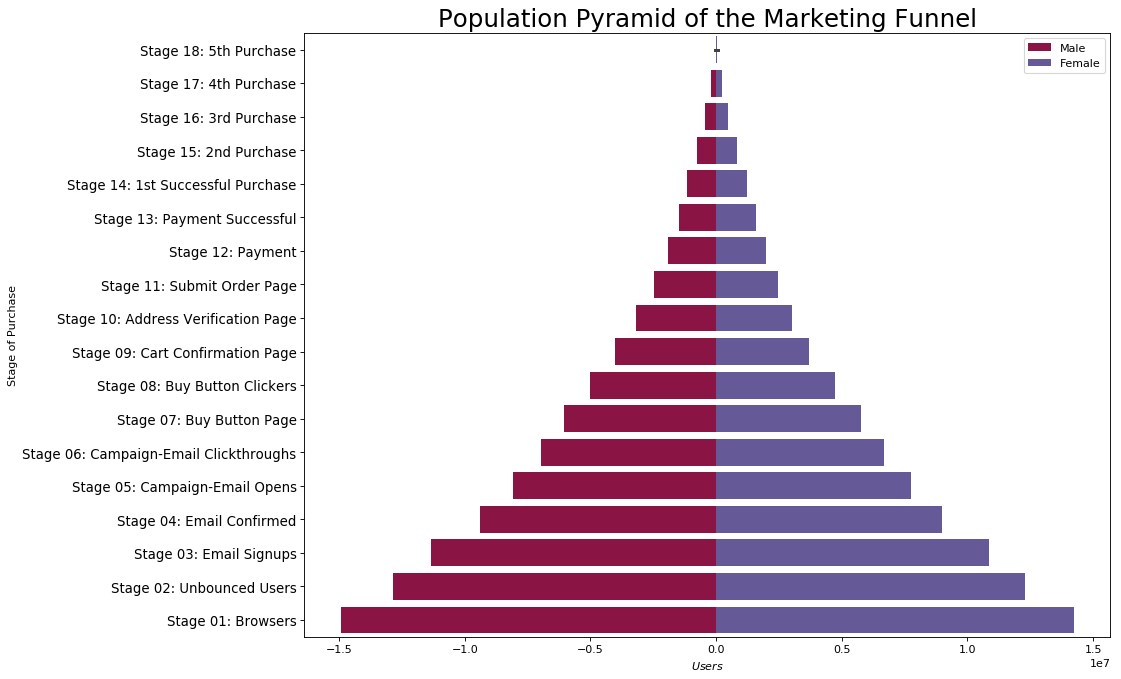

In [51]:
# Read data
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/email_campaign_funnel.csv")

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
group_col = 'Gender'
order_of_bars = df.Stage.unique()[::-1]
colors = [plt.cm.Spectral(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]

for c, group in zip(colors, df[group_col].unique()):
    sns.barplot(x='Users', y='Stage', data=df.loc[df[group_col]==group, :], order=order_of_bars, color=c, label=group)

# Decorations    
plt.xlabel("$Users$")
plt.ylabel("Stage of Purchase")
plt.yticks(fontsize=12)
plt.title("Population Pyramid of the Marketing Funnel", fontsize=22)
plt.legend()
plt.show()

In [96]:
df

,Stage,Gender,Users
0,Stage 01: Browsers,Male,-1.492762e+07
1,Stage 02: Unbounced Users,Male,-1.286266e+07
2,Stage 03: Email Signups,Male,-1.136190e+07
3,Stage 04: Email Confirmed,Male,-9.411708e+06
4,Stage 05: Campaign-Email Opens,Male,-8.074317e+06
5,Stage 06: Campaign-Email Clickthroughs,Male,-6.958512e+06
6,Stage 07: Buy Button Page,Male,-6.045363e+06
7,Stage 08: Buy Button Clickers,Male,-5.029954e+06
8,Stage 09: Cart Confirmation Page,Male,-4.008034e+06
9,Stage 10: Address Verification Page,Male,-3.172555e+06
